**Installing dependencies**

In [ ]:
#!pip install -r requirements.txt

**Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone

**Reading the data**

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X = train.drop(['id', 'efficiency'], axis = 1)
y = train['efficiency']

**Exploratory Data Analysis**

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         18999 non-null  float64
 1   irradiance          19013 non-null  float64
 2   humidity            20000 non-null  object 
 3   panel_age           18989 non-null  float64
 4   maintenance_count   18973 non-null  float64
 5   soiling_ratio       18990 non-null  float64
 6   voltage             19007 non-null  float64
 7   current             19023 non-null  float64
 8   module_temperature  19022 non-null  float64
 9   cloud_coverage      18990 non-null  float64
 10  wind_speed          20000 non-null  object 
 11  pressure            20000 non-null  object 
 12  string_id           20000 non-null  object 
 13  error_code          14088 non-null  object 
 14  installation_type   14972 non-null  object 
dtypes: float64(9), object(6)
memory usage: 2.3+ MB


In [5]:
X.isnull().sum()

,0
temperature,1001
irradiance,987
humidity,0
panel_age,1011
maintenance_count,1027
soiling_ratio,1010
voltage,993
current,977
module_temperature,978
cloud_coverage,1010


In [6]:
X.head(5)

,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type
0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN
1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis
2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN
3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis
4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed


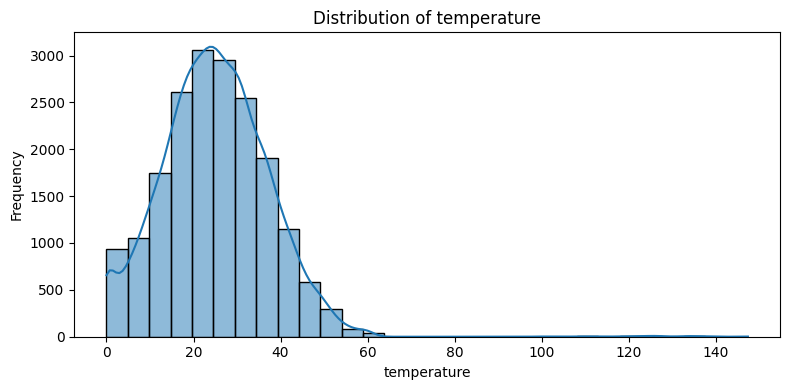

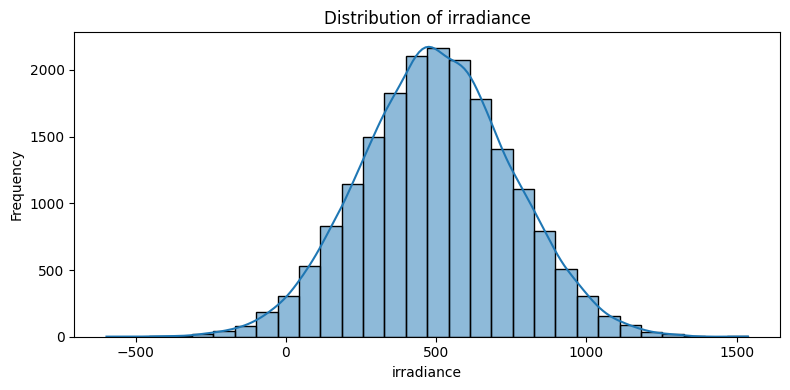

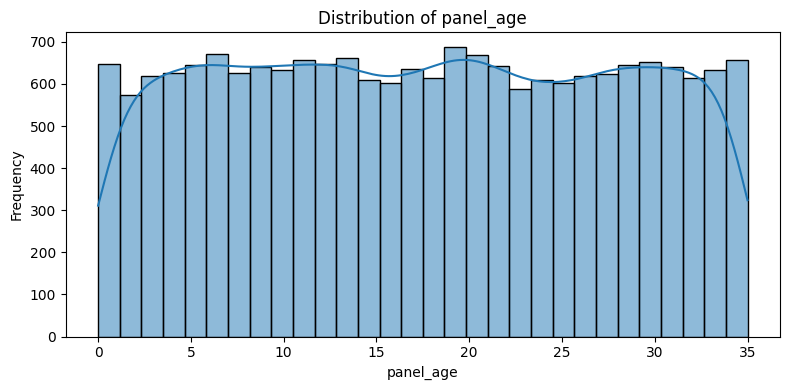

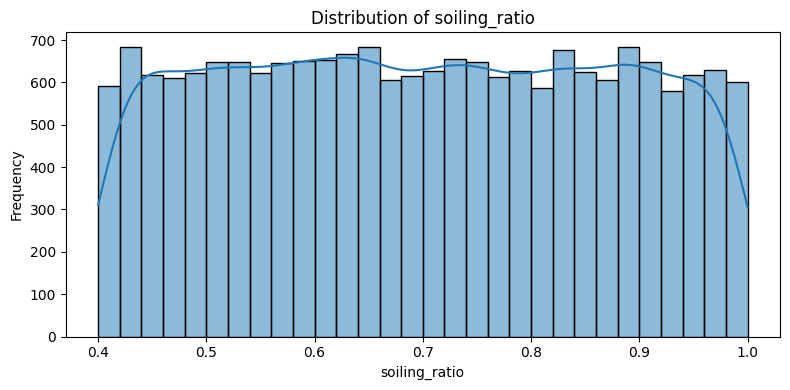

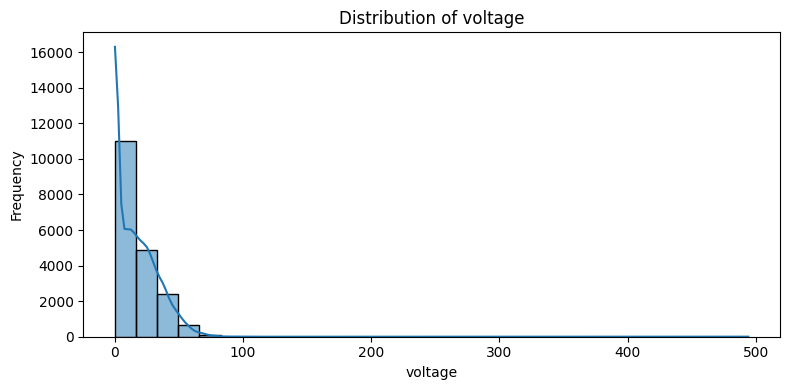

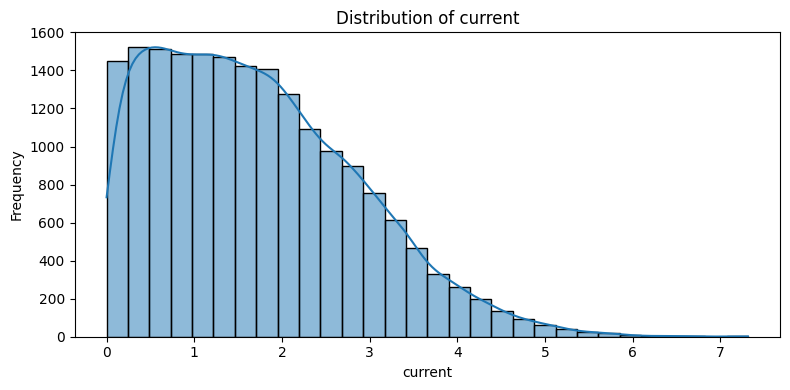

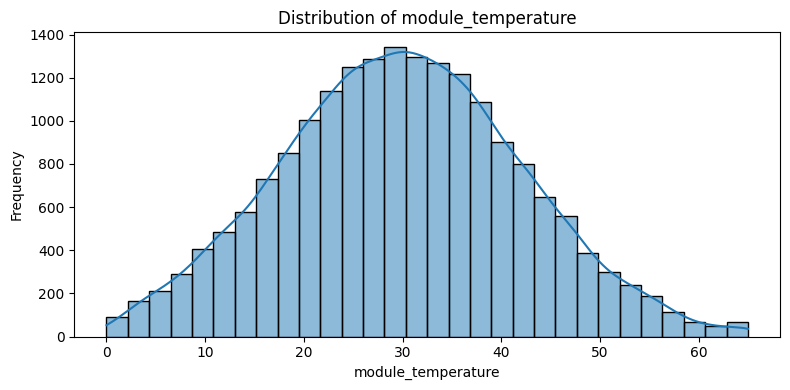

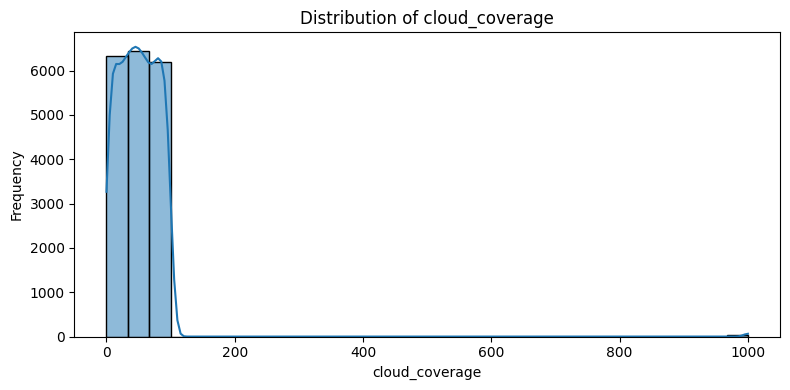

In [7]:
cols = ['temperature', 'irradiance', 'panel_age', 'soiling_ratio', 'voltage', 'current','module_temperature','cloud_coverage']
for col in cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

<Figure size 1000x800 with 0 Axes>

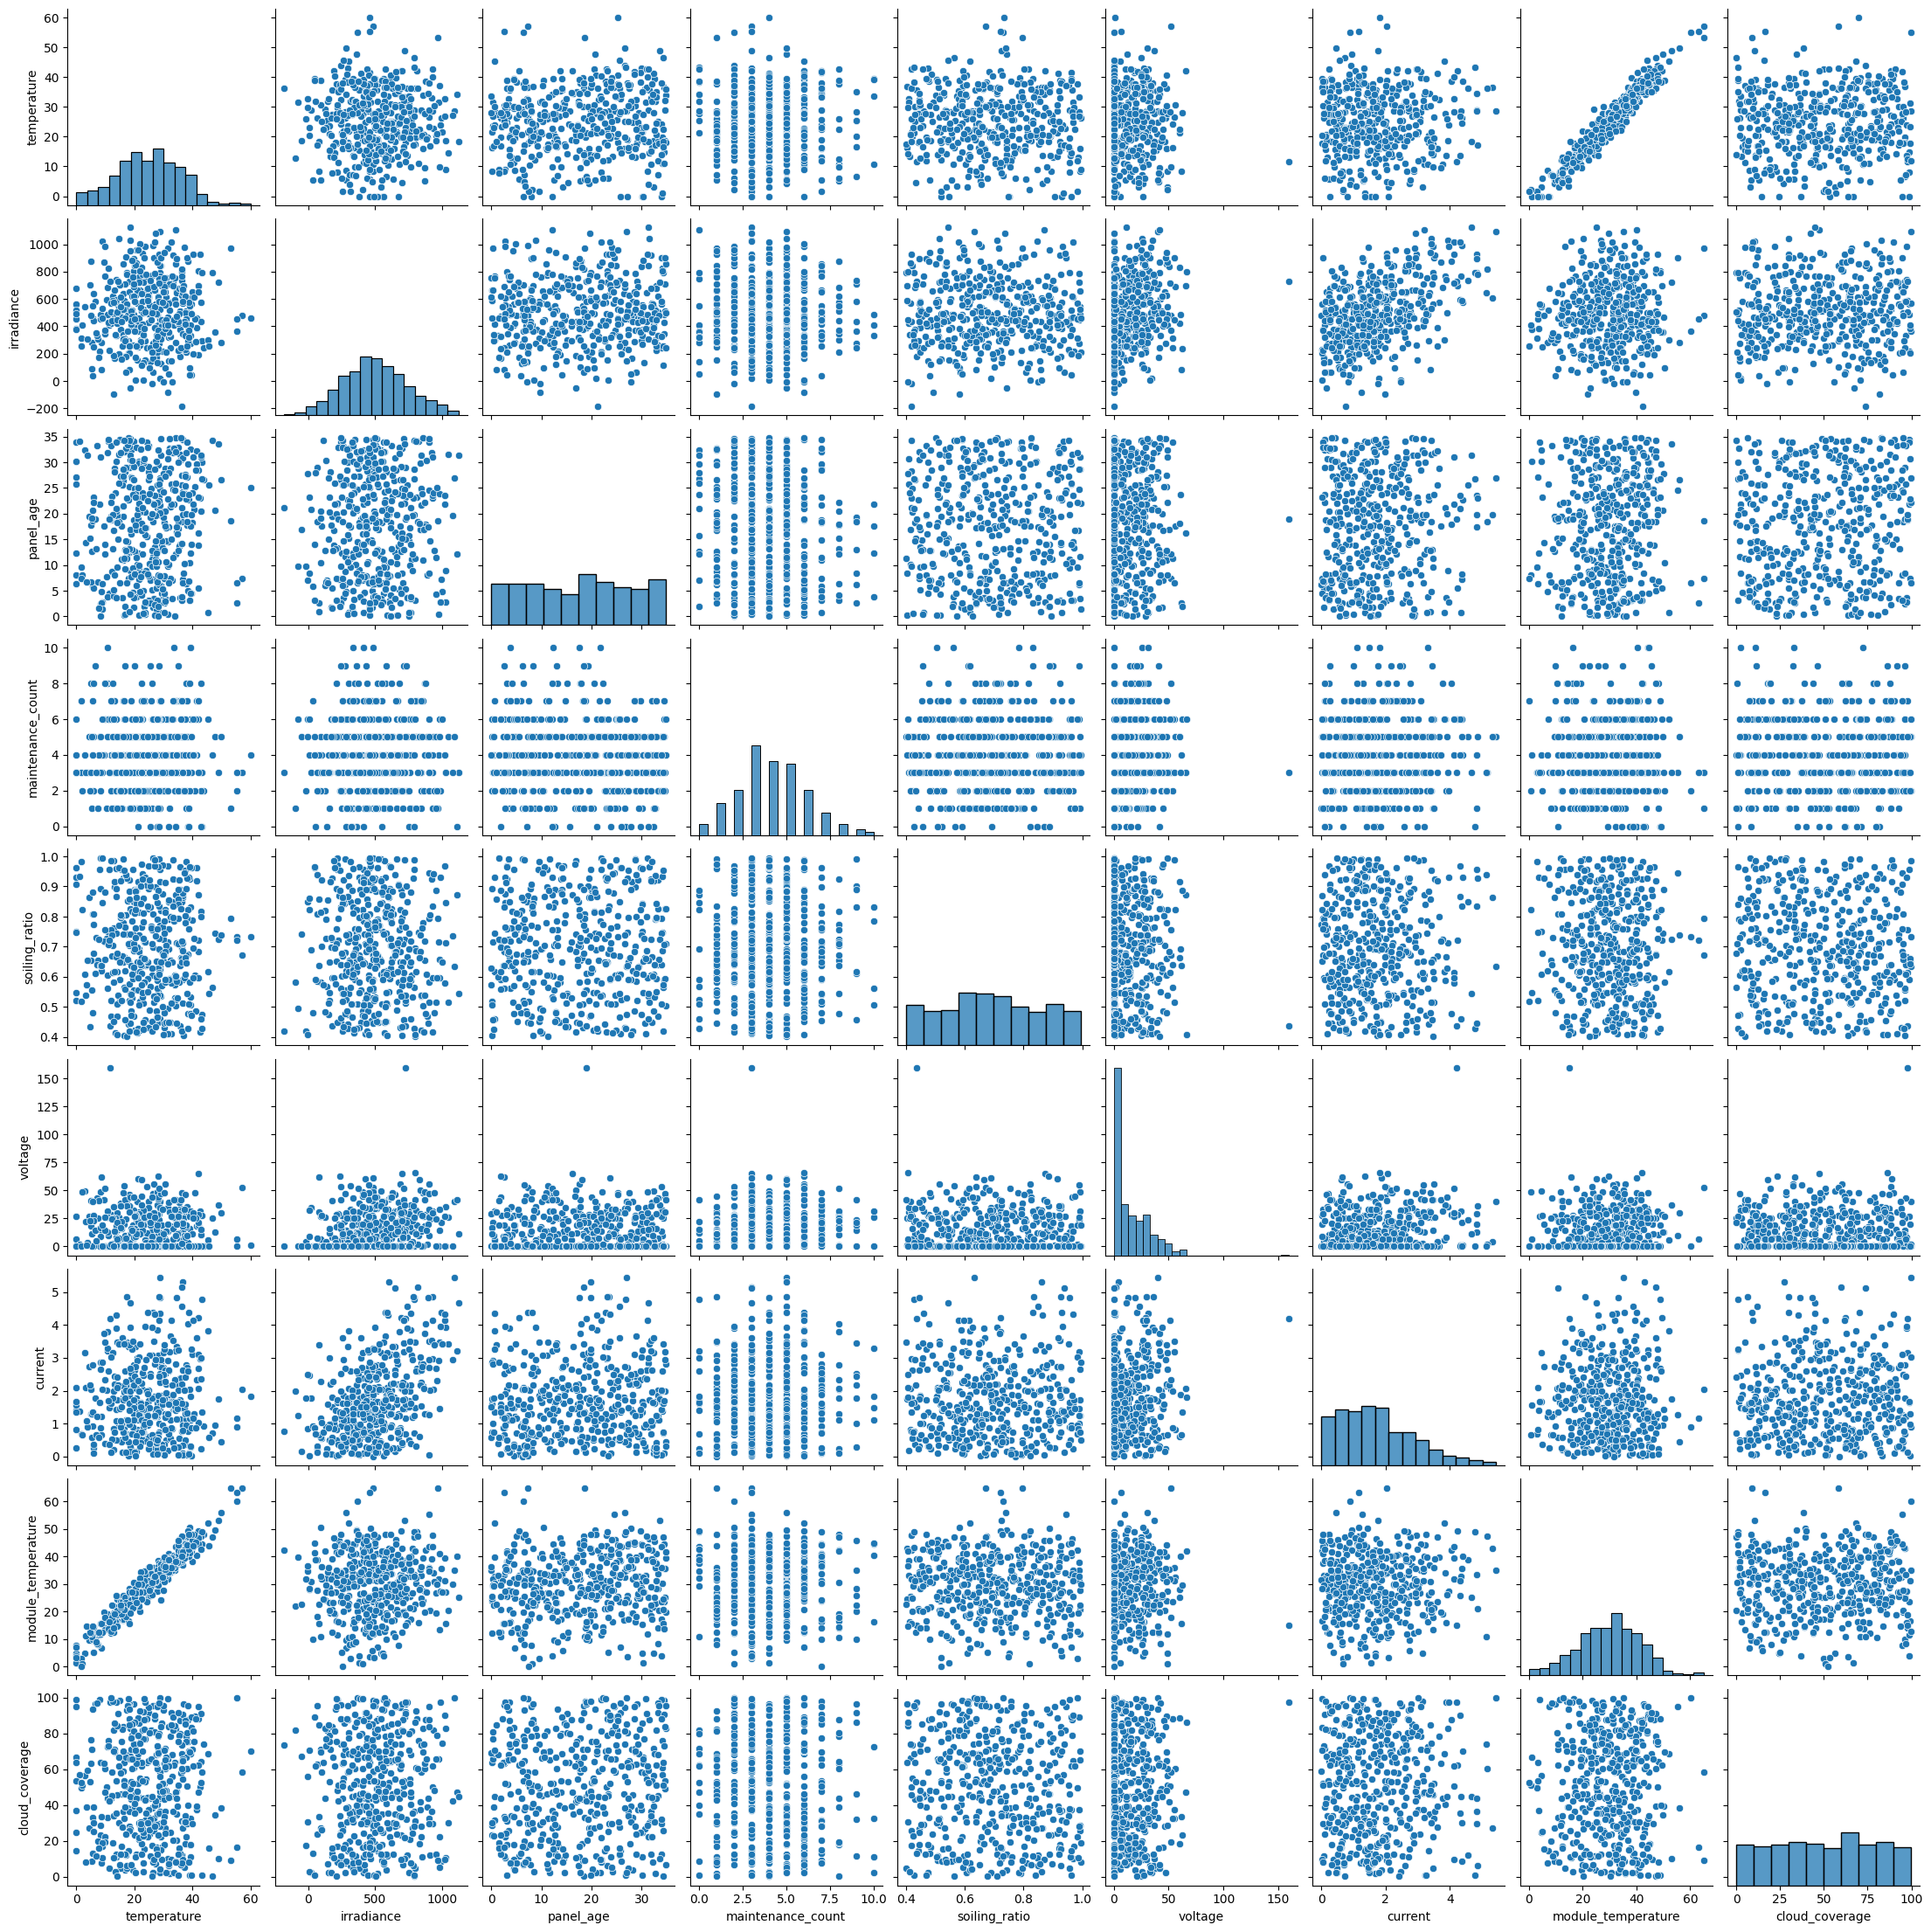

In [8]:
plt.figure(figsize=(10, 8))
sampled_df = X.sample(n=500, random_state=42)
sns.pairplot(sampled_df)
plt.show()

**Feature Engineering & Data Preprocessing**

In [9]:
def preprocess(df):
    df = df.copy()

    # Fill missing categorical
    if 'maintenance_count' in df.columns:
        if df['maintenance_count'].isnull().any():
            mode_val = df[df['maintenance_count'].notna()]['maintenance_count'].mode()[0]
            df['maintenance_count'] = df['maintenance_count'].fillna(mode_val)

    # Fill missing numerical values
    num_cols = ['temperature', 'irradiance', 'panel_age', 'soiling_ratio', 'voltage',
                'current', 'module_temperature', 'cloud_coverage']
    for col in num_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # Impute categorical missing using random selection from non-missing values
    for col in ['error_code', 'installation_type']:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda x: np.random.choice(df[col].dropna()) if pd.isna(x) else x
            )

    # Label Encoding
    label_cols = ['string_id', 'error_code', 'installation_type']
    le = LabelEncoder()
    for col in label_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Clean and convert string numbers to float
    def clean_and_convert_to_float(inner_df, columns=None):
        if columns is None:
            columns = inner_df.select_dtypes(include='object').columns
        for col in columns:
            try:
                inner_df[col] = (
                    inner_df[col].astype(str)
                    .str.extract(r'([-+]?\d*\.\d+|\d+)')
                    .astype(float)
                )
            except Exception:
                pass
        return inner_df

    df = clean_and_convert_to_float(df)

    # Fill remaining numeric columns (specific list)
    extra_fill_cols = ['humidity', 'pressure', 'wind_speed']
    for col in extra_fill_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # Feature engineering
    if 'voltage' in df.columns:
        df['voltage'] = np.log1p(df['voltage'])

    if 'voltage' in df.columns and 'current' in df.columns:
        df['power_output'] = df['voltage'] * df['current']

    if 'irradiance' in df.columns:
        df['log_irradiance'] = np.log1p(df['irradiance'])

    if 'temperature' in df.columns:
        df['temp_squared'] = df['temperature'] ** 2

    # Scaling selected features
    features_to_scale = ['temperature','irradiance','humidity','panel_age',
                         'soiling_ratio','voltage','current','module_temperature',
                         'cloud_coverage','wind_speed','pressure','power_output',
                         'log_irradiance','temp_squared']

    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(df[features_to_scale])

    for i, col in enumerate(features_to_scale):
        df[col + '_scaled'] = scaled_features[:, i]

    # Drop unscaled versions of those features
    drop_cols = features_to_scale.copy()
    drop_cols.append('temperature_scaled')
    drop_cols.append('irradiance_scaled')
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    # Drop ID column if exists
    if 'id' in df.columns:
        df.drop('id', axis=1, inplace=True)

    return df


In [10]:
X = preprocess(X)

test = preprocess(test)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
X.head(5)

,maintenance_count,string_id,error_code,installation_type,humidity_scaled,panel_age_scaled,soiling_ratio_scaled,voltage_scaled,current_scaled,module_temperature_scaled,cloud_coverage_scaled,wind_speed_scaled,pressure_scaled,power_output_scaled,log_irradiance_scaled,temp_squared_scaled
0,4.0,0,0,0,-0.180283,0.881391,0.371202,0.291831,0.200978,-1.040842,0.235252,0.727795,0.435725,0.706884,0.223919,-0.759529
1,8.0,3,0,0,-0.995226,0.148711,-0.780776,0.133888,-0.877506,-0.152523,-0.159311,0.618476,0.936020,-0.338490,-1.182896,-0.019445
2,4.0,2,0,0,0.841828,-0.965013,0.439520,0.367295,1.596123,0.861769,0.000000,-0.752963,-0.152415,2.202440,0.508276,2.070341
3,3.0,0,0,0,0.942473,0.059168,0.493357,0.355152,-0.427221,1.782326,0.338268,0.177929,0.656368,0.142522,0.615788,2.964821
4,6.0,1,0,1,-0.461198,0.796251,-0.523237,-0.817329,-0.466361,-1.483584,-1.010525,-0.926680,-0.327639,-0.461723,-5.856733,-0.799696


In [12]:
test.head(5)

,maintenance_count,string_id,error_code,installation_type,humidity_scaled,panel_age_scaled,soiling_ratio_scaled,voltage_scaled,current_scaled,module_temperature_scaled,cloud_coverage_scaled,wind_speed_scaled,pressure_scaled,power_output_scaled,log_irradiance_scaled,temp_squared_scaled
0,6.0,2,1,2,0.819408,-0.215167,0.672529,-0.215674,-0.993492,-0.663959,-0.374589,-0.039726,1.608150,-0.429372,-2.850858,-0.416671
1,4.0,3,0,0,-0.576452,0.207938,-0.391147,0.220170,0.040932,0.465951,-0.399461,-0.443156,-1.554985,0.500389,0.582643,0.751370
2,3.0,3,1,0,0.115778,-0.967938,-0.316349,0.203443,0.030293,0.133136,0.384574,-0.163892,-1.041458,0.475839,-0.059310,0.658193
3,5.0,2,2,0,-0.015533,0.080721,0.000000,-0.160354,-0.541870,-0.271621,-0.177922,-0.633603,1.002353,-0.174297,-0.586658,-0.371416
4,8.0,1,2,1,-0.820742,0.000000,-0.481506,-0.036945,0.137640,0.000000,-0.006275,0.588159,-0.177612,0.329459,-0.227881,1.579697


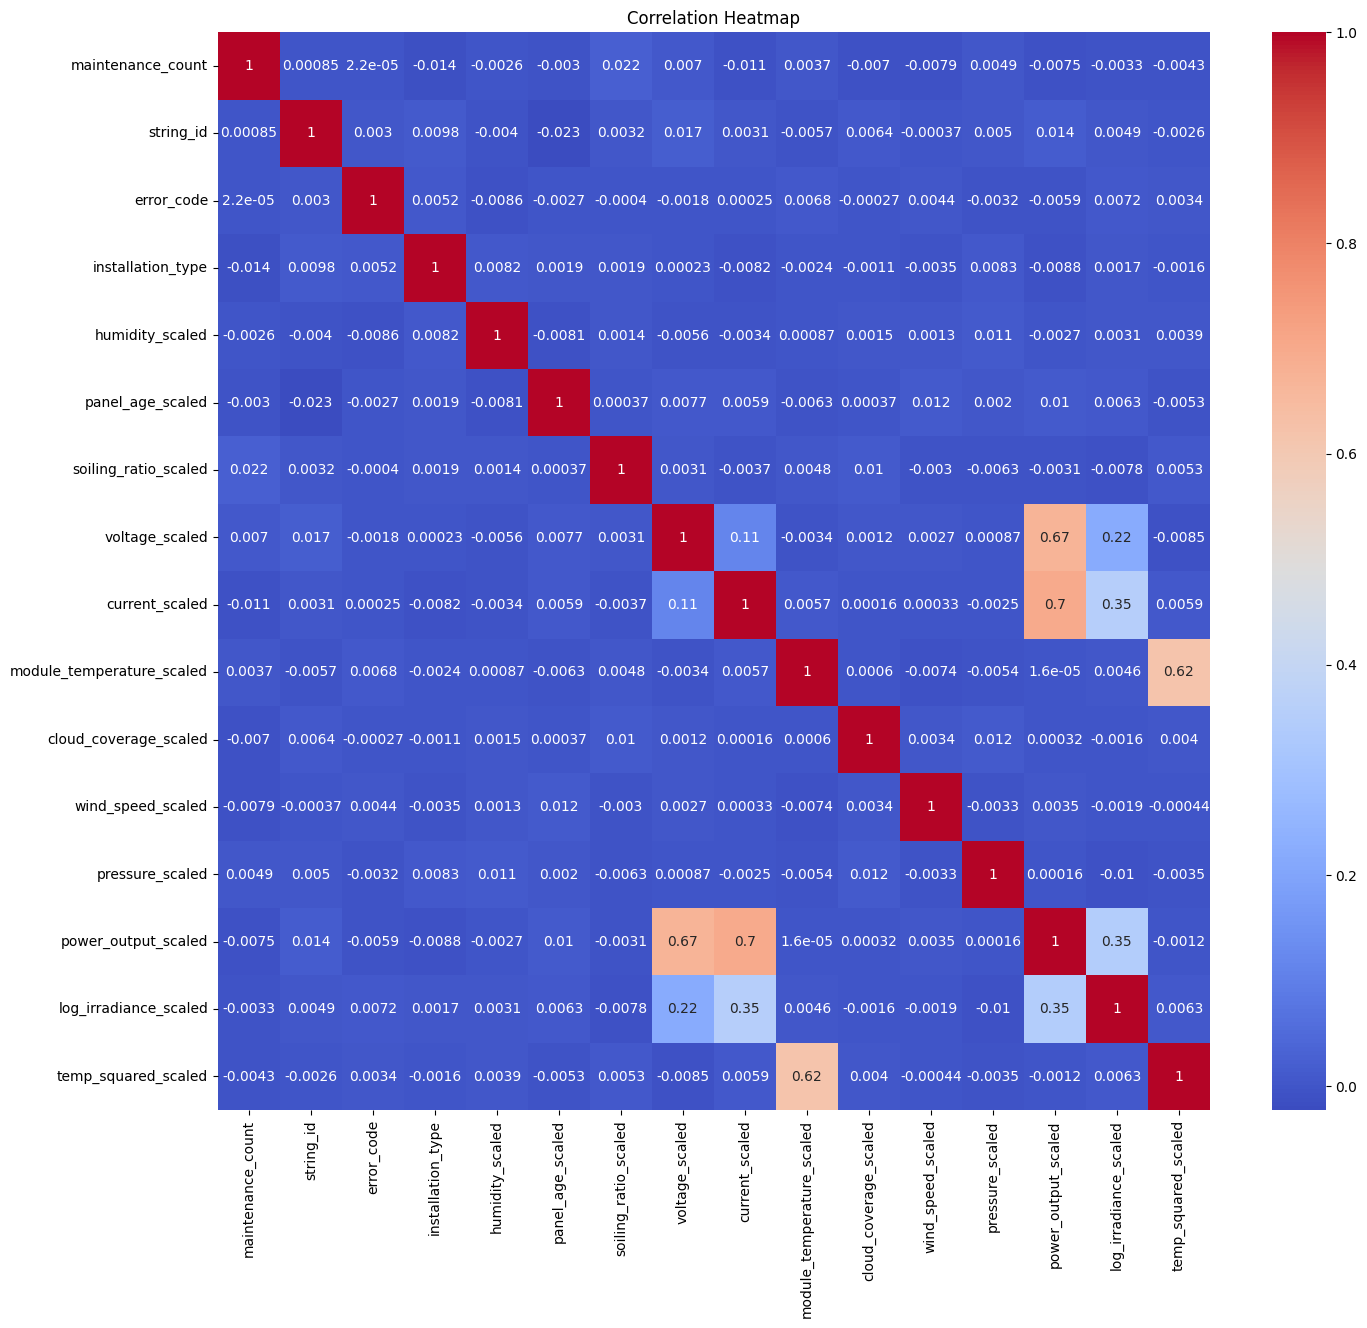

In [13]:
corr = X.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Splitting train and validation data**

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)

**Model**

In [15]:
# Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), rf_params,
                       scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# LGBM
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
lgbm_grid = GridSearchCV(LGBMRegressor(random_state=42, n_jobs=-1), lgbm_params,
                         scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
lgbm_grid.fit(X_train, y_train)
lgbm_best = lgbm_grid.best_estimator_

cat_params = {
    'iterations': [500, 1000],
    'depth': [6, 8],
    'learning_rate': [0.01, 0.05],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.2, 1.0]
}

#CatBoost
cat_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=0,
    random_seed=42,
    thread_count=-1
)

fit_params = {
    'early_stopping_rounds': 50,
    'eval_set': (X_val, y_val),
    'use_best_model': True
}

cat_grid = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

cat_grid.fit(X_train, y_train, **fit_params)
cat_best = cat_grid.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 16
[LightGBM] [Info] Start training from score 0.511069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

**OOF and Cross Validation**

In [16]:
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

base_models = [rf_best, lgbm_best, cat_best]
meta_model = Ridge()

oof_train = np.zeros((X_train.shape[0], len(base_models)))
oof_val = np.zeros((X_val.shape[0], len(base_models)))
oof_test = np.zeros((test.shape[0], len(base_models)))

for i, model in enumerate(base_models):
    oof_test_i = np.zeros((test.shape[0], N_SPLITS))
    oof_val_i = np.zeros((X_val.shape[0], N_SPLITS))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]

        m = clone(model)
        m.fit(X_tr, y_tr)

        oof_train[val_idx, i] = m.predict(X_fold_val)
        oof_val_i[:, fold] = m.predict(X_val)
        oof_test_i[:, fold] = m.predict(test)

    oof_val[:, i] = oof_val_i.mean(axis=1)
    oof_test[:, i] = oof_test_i.mean(axis=1)

oof_test[:, i] = oof_test_i.mean(axis=1)

# Cross-validation on meta-model using OOF features
cv_scores = cross_val_score(meta_model, oof_train, y_train,
                            cv=5, scoring='neg_root_mean_squared_error')

print("Meta-model CV RMSE scores (fold-wise):", -cv_scores)
print("Mean CV RMSE:", -np.mean(cv_scores))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 16
[LightGBM] [Info] Start training from score 0.510809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

**RMSE AND Custom Score on Validation data**

In [17]:
meta_model.fit(oof_train, y_train)

val_preds = meta_model.predict(oof_val)

val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
custom_score = 100 * (1 - val_rmse)

print(f"Validation RMSE: {val_rmse:.5f}")
print(f"Custom Score on Validation Set: {custom_score:.5f}")

Validation RMSE: 0.10610
Custom Score on Validation Set: 89.38951


**Submission file**

In [18]:
meta_model.fit(oof_train, y_train)
final_preds = meta_model.predict(oof_test)

submission = pd.DataFrame({
    "id": pd.read_csv("test.csv")['id'],  # or test_df["Id"] if 'Id' column exists
    "efficiency": final_preds
})
submission.to_csv("submission.csv", index=False)
print("Submission saved.")

Submission saved.
